In [1]:
from PIL import Image
from PIL import GifImagePlugin
import numpy as np
import matplotlib.pyplot as plt
import os
from warnings import simplefilter
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml
mnist=fetch_openml('mnist_784')
simplefilter(action='ignore', category=FutureWarning)
file_dir="C:/Users/rhish/Downloads/archive/data"
file_list=os.listdir(file_dir)
scaler=StandardScaler()
import seaborn as sns
import random

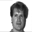

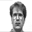

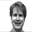

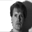

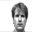

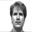

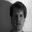

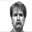

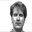

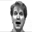

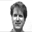

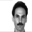

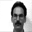

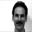

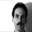

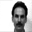

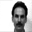

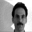

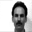

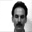

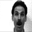

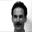

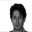

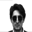

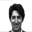

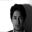

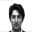

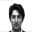

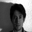

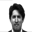

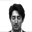

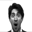

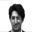

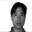

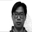

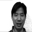

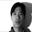

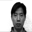

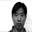

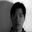

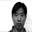

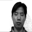

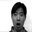

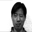

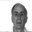

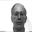

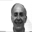

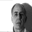

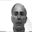

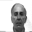

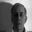

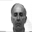

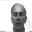

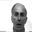

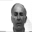

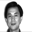

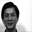

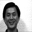

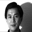

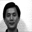

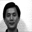

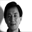

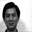

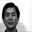

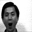

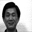

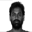

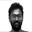

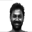

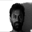

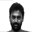

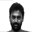

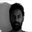

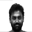

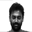

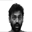

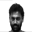

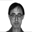

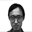

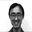

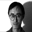

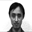

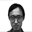

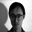

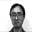

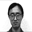

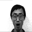

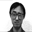

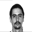

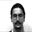

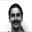

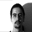

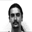

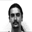

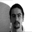

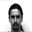

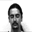

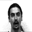

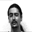

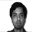

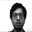

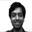

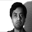

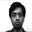

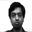

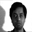

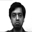

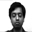

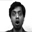

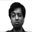

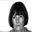

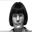

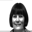

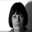

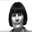

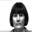

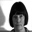

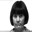

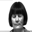

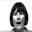

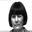

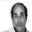

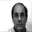

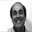

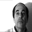

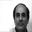

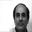

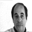

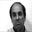

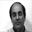

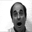

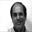

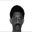

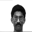

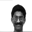

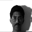

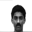

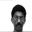

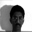

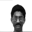

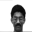

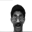

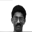

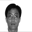

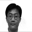

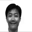

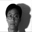

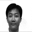

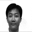

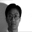

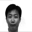

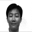

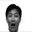

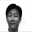

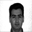

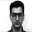

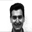

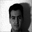

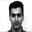

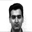

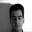

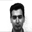

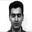

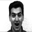

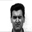

In [2]:
img=[]
for file in file_list:
    if(file=='Readme.txt'):
        continue
    else:
        path=os.path.join(file_dir,file)
        image=Image.open(path)
        image=image.resize((32,32))
        display(image)
        image=np.asarray(image)
        image=image.reshape(-1,)
        img.append(image)

In [3]:
#getting image dimensions as a vector
img[0].shape
# img=scaler.fit_transform(img)

(1024,)

In [4]:
labels=[x.split('.')[1] for x in file_list]
labels.remove('txt')
unique_labels=list(set(labels))
unique_labels

['sad',
 'glasses',
 'happy',
 'centerlight',
 'surprised',
 'normal',
 'sleepy',
 'leftlight',
 'rightlight',
 'wink',
 'noglasses']

In [5]:
len(labels)

165

In [6]:
img=np.array(img)
img.shape

(165, 1024)

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time
import pandas as pd
import math
from scipy.linalg import eigh
#returns distance between xi and xj
def dist(xi,xj,sigma=1,method='cosine'):
    if(method=='gauss'):
        return math.e**(np.linalg.norm(xi-xj)**2/2*sigma**2)
    if(method=='cosine'):
        return xi@xj/(np.linalg.norm(xi)*np.linalg.norm(xj))
    
#returns W
def build_graph(data,labels,method='LDA'):
    
    W=np.zeros((len(data),len(data)))
    labels=np.array(labels)
    data=np.array(data)
    if(method=='LDA'):
        unique_labels=list(np.unique(labels))
#         print(unique_labels)
#         print(type(unique_labels))
        count_classes={x:0 for x in unique_labels}
#         print(count_classes)
#         print(type(labels))
#         print(labels)
        for i in labels:
#             print(i)
#             print(type(i))
            count_classes[i]+=1
        for i in range(len(data)):
            for j in range(i,len(data)):
                if(labels[i]==labels[j]):
                    W[i,j]=1/count_classes[labels[i]]
                    W[j,i]=W[i,j]
                else:
                    W[i,j]=0
                    W[j,i]=0
    if(method=='LPP'):
        knn=KNeighborsClassifier(n_neighbors=1,metric='euclidean')
        knn.fit(data,labels)
        for i in range(len(data)):
            s=0
            for j in range(i,len(data)):
                kj=knn.kneighbors(data[j].reshape((1,-1)))
                ki=knn.kneighbors(data[i].reshape((1,-1)))
                if(j in ki or i in kj):
                    W[i,j]=dist(data[i],data[j])
                    W[j,i]=W[i,j]
                else:
                    W[i,j]=0
                    W[j,i]=0
# #     sums=[]
#     for i in range(len(data)):
#         s=0
#         for j in range(len(data)):
# #             if(i!=j):
#             s+=W[i,j]
#         sums.append(s)
    D=np.zeros((len(data),len(data)))
    for i in range(len(data)):
        D[i,i]=np.sum(W[i,:])
    return W,D

# def split_train_test(data,labels,tsize=10):
#     x_train=[]
#     y_train=[]
#     x_test=[]
#     y_test=[]
#     labels=np.array(labels)
#     unique=np.unique(labels)
#     indices=[]
# #     print(data.shape)
#     for x in unique:
#         dfilter1=np.where((labels==x))
#         new_x=data[dfilter1]
#         new_y=labels[dfilter1]
#         indices.append(dfilter1)
    
#     y_train=np.array(y_train)
#     y_test=np.array(y_test)
#     x_test=np.array(x_test)
#     x_train=np.array(x_train)
#     y_train=y_train.ravel()
#     y_test=y_test.ravel()
#     print('x_train shape',x_train.shape)
#     print('x_test shape',x_test.shape)
#     print('y_train shape',y_train.shape)
#     print('y_test shape',y_test.shape)
#     x_train=np.reshape(x_train,(-1,x_train.shape[2]))
#     x_test=np.reshape(x_test,(-1,x_test.shape[2]))
# #     print(y_test)
    
#     return x_train,x_test,y_train,y_test


def split_train_test(data, labels,tsize=10):
    x_train = []
    y_train = []
    x_test = []
    y_test = []
#     print(len(labels))
    unique_labels = np.unique(labels)
    
    for label in unique_labels:
        labels=np.array(labels)
        indices = np.where(labels == label)[0]
#         print('indices',indices)
        np.random.shuffle(indices)
        selected_indices = indices[:tsize]
        selected_indices_test=indices[tsize:]
        labels=list(labels)
        x_train.append(data[selected_indices])
        arr_test1=[]
        arr_test2=[]
        for i in selected_indices:
            arr_test1.append(labels[i])
        for i in selected_indices_test:
            arr_test2.append(labels[i])
#         print('size of arr_test 1',arr_test1.shape)
        y_train.append(arr_test1)
        x_test.append(data[selected_indices_test])
        y_test.append(arr_test2)
    x_train = np.concatenate(x_train)
    y_train = np.concatenate(y_train)
    x_test = np.concatenate(x_test)
    y_test = np.concatenate(y_test)
    print('x_train shape',x_train.shape)
    return x_train, x_test, y_train,y_test

def algo_choice(X,Y,G_prev,smoothing_term,mu=0.1,choice=None):
    if(choice==1):
        res=X.T@np.linalg.inv(G_prev)@X
        return 1,np.linalg.inv(G_prev)@(X@(np.linalg.inv(res)@Y))
    elif(choice==2):
        res=X.T@np.linalg.inv(G_prev)@X
        shape=np.shape(res)[0]
        res=res+1/(2*mu)*np.identity(shape)
        return 2,np.linalg.inv(G_prev)@(X@(np.linalg.inv(res)@Y))
#         return A=(np.linalg.inv(G_prev)@X)@np.linalg.inv(X.T@np.linalg.inv(G_prev)@X+1/(2*0.01)*np.identity(len(img)))@Y #Algo 2
    print(X.shape)
    print(Y.shape)
    augmented=np.vstack((X,Y))
    r1=np.linalg.matrix_rank(augmented)
    r2=np.linalg.matrix_rank(X)
    n=1
#     G_prev=G_prev+smoothing_term*np.identity(G_prev.shape[0])
    for i in X.shape:
        n=n*i
    if(r1==r2 and r1<n):
        res=X.T@np.linalg.inv(G_prev)@X
        return 1,np.linalg.inv(G_prev)@(X@np.linalg.inv(res)@Y)
    else:
        res=X.T@np.linalg.inv(G_prev)@X
        shape=np.shape(res)[0]
        res=res+1/(2*mu)*np.identity(shape)
        return 2,np.linalg.inv(G_prev)@(X@(np.linalg.inv(res)@Y))

#returns projected data
def preprocessing(img,labels,method='PCA',plot=True,choice=None,tsize=10):
    if(method=='PCA'):
        from sklearn.decomposition import PCA
        pca=PCA(n_components=min(len(img),img[0].shape[0]))
        new_img=pca.fit_transform(img)
        if(plot==True):
            plt.plot(np.cumsum(pca.explained_variance_ratio_*100))
            plt.title("PCA: Plot to choose number of components")
            plt.xlabel('Number of components')
            plt.ylabel('Variance')
            plt.grid()
            plt.show()
        tol=99
        count=0
        for var in np.cumsum(pca.explained_variance_ratio_*100):
            count+=1
            if(var>=tol):
                break
        pca=PCA(n_components=count)
#         print('With tolerance (of variance, in percentage)=',tol,'\nNumber of components chosen for PCA:',count)
        new_img=pca.fit_transform(img)
        return new_img
    
    if(method=='FSSL_LDA' or method=='FSSL_LPP'):
#         print("entered here")
        #number of components=99=feature space in y
        #algo1
        x_train,x_test,y_train,y_test=split_train_test(img,labels,tsize)
        x_train=np.array(x_train)
        y_train=np.array(y_train)
        x_test=np.array(x_test)
        y_test=np.array(y_test)
        print('shape of x_train',x_train.shape)
        print('shape of y_train',y_train.shape)
        print('shape of y_test',y_test.shape)
        method=method.split('_')[1]
        W,D=build_graph(x_train,y_train,method)
        #continue algo 1 
        Y=eigh(W,D)[1]
        X=x_train.T                                          
        A_prev=np.zeros(X.shape)
        G_prev=np.identity(A_prev.shape[0])
        smoothing_term=0.01
        niter=0
        max_niter=10000
        flag=0
#         check whether X^TA=Y has a solution, infinitely many solutions or no solution
        while(True):
            
#             try:
            choice,A=algo_choice(X,Y,G_prev,smoothing_term,0.1,choice) #Algo chooser
#                 A=(np.linalg.inv(G_prev)@X)@np.linalg.inv(X.T@np.linalg.inv(G_prev)@X+1/(2*0.01)*np.identity(len(img)))@Y #Algo 2
#             except:
#                 A=A_prev
#                 break

            G=np.zeros(G_prev.shape)
            niter+=1
            if(niter%10==0):
                smoothing_term=smoothing_term/2
            for i in range(G.shape[0]):
                val=np.linalg.norm(A[i,:])
                if(val==0):
                    G[i,i]=0
                else:
                    G[i,i]=1/val
                    
                G[i,i]+=smoothing_term
            if(np.linalg.norm(A-A_prev)<0.001 or niter>max_niter):
                print("Error", np.linalg.norm(A-A_prev))
                break
            print("Step",niter,"Error", np.linalg.norm(A-A_prev))
            A_prev=A
            G_prev=G
        print("-----END-----")
        print("Model:",method)
        print("Choice:",choice)
        print("")
#         print("Heatmap of projection matrix")
#         sns.heatmap(A)
        return A
        
#returns accuracy and time taken
def baseline(data,labels,tsize,seed,x_train=[],x_test=[],y_train=[],y_test=[]):
    start=time.time()
    if(len(x_train)!=0 and len(x_test)!=0 and len(y_train)!=0 and len(y_test)!=0):
        if(len(x_train)!=len(y_train) or len(x_test)!=len(y_test)):
            print("x_train length",len(x_train))
            print('y_train length',len(y_train))
            print("x_test length",len(x_test))
            print('y_test length',len(y_test))
            raise Exception("Unequal size of x_train and x_test or y_train and y_test.")
    else:
#         print(data.shape)
#         print(labels.shape)
        x_train,x_test,y_train,y_test=train_test_split(data,labels,train_size=tsize,random_state=seed)
    
    knn=KNeighborsClassifier(n_neighbors=1,metric='euclidean')
    knn.fit(x_train,y_train)
    pred=knn.predict(x_test)
    end=time.time()
    accuracy=accuracy_score(pred,y_test)
    time_taken=round((end-start)*1000,3)
#     print("Accuracy=",accuracy,time_taken)
    return accuracy,time_taken
#returns accuracy and time taken

def LDA(data,labels,tsize,seed):
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    start=time.time()
    data=preprocessing(data,labels,'PCA',False)
    x_train,x_test,y_train,y_test=train_test_split(data,labels,train_size=tsize,random_state=seed)
    lda=LinearDiscriminantAnalysis()
    new_img=lda.fit_transform(data,labels)
    pred=lda.predict(x_test)
    end=time.time()
    accuracy=accuracy_score(pred,y_test)
    time_taken=round((end-start)*1000,3)
#     print("Accuracy=",accuracy,time_taken)
    return new_img,accuracy,time_taken
# def fisher_score(data):
#     nfeatures=len(data[0])
#     nsamples=len(data)
#     for i in range(nfeatures):
#         #comment

In [8]:
def create_table(data,labels,model,choice,train_sizes,extra_time=0):
#     train_sizes=[10,20,30]
    table={}
    for size in train_sizes:
        accuracies=[]
        times=[]
        a=0
        t=0
        count_unique=len(set(labels))
        for i in range(20):
            new_data=data
            x_train,x_test,y_train,y_test=split_train_test(new_data,labels,size)
            ts=max(len(data)-1,len(x_train))
            if(model is LDA):
                new_data,a, t=LDA(data,labels,ts,i)
        
            if(choice=='FSSL_LDA' or choice=='FSSL_LPP'):
#                 x_train,x_test,y_train,y_test=split_train_test(data,labels,size)
                A=preprocessing(data,labels,choice,False,tsize=size) #projection matrix
#                 img,labels,method='PCA',plot=True,choice=None,tsize=10
#                 print("A",A)
                print('New data shape',new_data.shape)
                print('A shape',A.shape)
                new_data=new_data@A
                print('new_data shape now',new_data.shape)
#                 print('Heatmap of projected image')
#                 sns.heatmap(new_data)
                a,t=baseline(new_data,labels,ts,i,x_train,x_test,y_train,y_test)
                accuracies.append(a)
                times.append(t+extra_time)
                continue
            if(choice=='LDA'):
                accuracies.append(a)
                times.append(t)
                continue

            else:      
                a, t=baseline(new_data,labels,ts,i)
                accuracies.append(a)
                times.append(t+extra_time)
        a=sum(accuracies)/len(accuracies)
        t=str(round(sum(times)/len(times),3))+' ms'
        table[size]=[a,t]
    table=pd.DataFrame(table)
    table=table.rename(index={0:'Accuracy',1:'Time taken'})
    return table

In [9]:
train_sizes=[5,6,7]
create_table(img,labels,baseline,'base',train_sizes)

x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)


,5,6,7
Accuracy,0.1,0.1,0.1
Time taken,2.787 ms,1.665 ms,2.299 ms


In [10]:
create_table(img,labels,LDA,'base',train_sizes)

x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)


,5,6,7
Accuracy,0.4,0.4,0.35
Time taken,3.003 ms,0.551 ms,1.555 ms


In [11]:
create_table(img,labels,LDA,'LDA',train_sizes)

x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)


,5,6,7
Accuracy,0.8,0.75,0.8
Time taken,26.852 ms,29.525 ms,33.898 ms


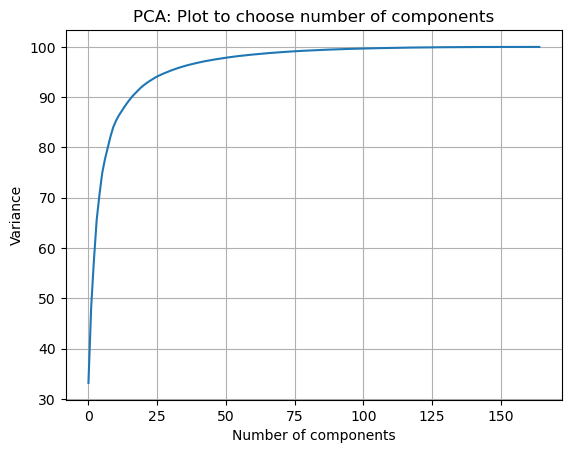

x_train shape (55, 73)
x_train shape (55, 73)
x_train shape (55, 73)
x_train shape (55, 73)
x_train shape (55, 73)
x_train shape (55, 73)
x_train shape (55, 73)
x_train shape (55, 73)
x_train shape (55, 73)
x_train shape (55, 73)
x_train shape (55, 73)
x_train shape (55, 73)
x_train shape (55, 73)
x_train shape (55, 73)
x_train shape (55, 73)
x_train shape (55, 73)
x_train shape (55, 73)
x_train shape (55, 73)
x_train shape (55, 73)
x_train shape (55, 73)
x_train shape (66, 73)
x_train shape (66, 73)
x_train shape (66, 73)
x_train shape (66, 73)
x_train shape (66, 73)
x_train shape (66, 73)
x_train shape (66, 73)
x_train shape (66, 73)
x_train shape (66, 73)
x_train shape (66, 73)
x_train shape (66, 73)
x_train shape (66, 73)
x_train shape (66, 73)
x_train shape (66, 73)
x_train shape (66, 73)
x_train shape (66, 73)
x_train shape (66, 73)
x_train shape (66, 73)
x_train shape (66, 73)
x_train shape (66, 73)
x_train shape (77, 73)
x_train shape (77, 73)
x_train shape (77, 73)
x_train sha

,5,6,7
Accuracy,0.1,0.1,0.1
Time taken,2.029 ms,0.396 ms,0.0 ms


In [12]:
create_table(preprocessing(img,labels),labels,baseline,'base',train_sizes)

In [13]:
# start=time.time()
# fssl_img=preprocessing(img,labels,method='FSSL_LDA')
# end=time.time()
# extra=end-start
create_table(img,labels,baseline,'FSSL_LDA',train_sizes)

x_train shape (55, 1024)
x_train shape (55, 1024)
shape of x_train (55, 1024)
shape of y_train (55,)
shape of y_test (110,)
(1024, 55)
(55, 55)
Step 1 Error 0.023698638149413465
Step 2 Error 0.010930336487010238
Step 3 Error 0.003991742310013967
Step 4 Error 0.002801209573918363
Step 5 Error 0.00205987142926275
Step 6 Error 0.0015770016902797047
Step 7 Error 0.001257204783420682
Step 8 Error 0.00103425338551511
Error 0.0008717025609143197
-----END-----
Model: LDA
Choice: 2

New data shape (165, 1024)
A shape (1024, 55)
new_data shape now (165, 55)
x_train shape (55, 1024)
x_train shape (55, 1024)
shape of x_train (55, 1024)
shape of y_train (55,)
shape of y_test (110,)
(1024, 55)
(55, 55)
Step 1 Error 0.016021397925851253
Step 2 Error 0.0054080829155463426
Step 3 Error 0.002903946727031687
Step 4 Error 0.002089034441743744
Step 5 Error 0.0015602917468637437
Step 6 Error 0.0012214643249247952
Error 0.0009964271841951316
-----END-----
Model: LDA
Choice: 2

New data shape (165, 1024)
A sh

Step 1 Error 0.02061640335227058
Step 2 Error 0.00917399054863203
Step 3 Error 0.003105308080506605
Step 4 Error 0.0021538686701901267
Step 5 Error 0.0015955693254239142
Step 6 Error 0.0012379274713951677
Step 7 Error 0.0010046596031523679
Error 0.0008442422329718307
-----END-----
Model: LDA
Choice: 2

New data shape (165, 1024)
A shape (1024, 55)
new_data shape now (165, 55)
x_train shape (55, 1024)
x_train shape (55, 1024)
shape of x_train (55, 1024)
shape of y_train (55,)
shape of y_test (110,)
(1024, 55)
(55, 55)
Step 1 Error 0.015468473745061558
Step 2 Error 0.0045756068062722186
Step 3 Error 0.0030514067660668475
Step 4 Error 0.0022522776541074297
Step 5 Error 0.0017257626606313765
Step 6 Error 0.001364492275659783
Step 7 Error 0.001110916970186405
Error 0.000926402386869172
-----END-----
Model: LDA
Choice: 1

New data shape (165, 1024)
A shape (1024, 55)
new_data shape now (165, 55)
x_train shape (55, 1024)
x_train shape (55, 1024)
shape of x_train (55, 1024)
shape of y_train (5

Step 7 Error 0.001019743187070367
Error 0.0008674210758819914
-----END-----
Model: LDA
Choice: 2

New data shape (165, 1024)
A shape (1024, 66)
new_data shape now (165, 66)
x_train shape (66, 1024)
x_train shape (66, 1024)
shape of x_train (66, 1024)
shape of y_train (66,)
shape of y_test (99,)
(1024, 66)
(66, 66)
Step 1 Error 0.02102011804495589
Step 2 Error 0.00694282180856455
Step 3 Error 0.0034774169859498076
Step 4 Error 0.0025322401601533748
Step 5 Error 0.0018931483435610404
Step 6 Error 0.0014643596585899366
Step 7 Error 0.0011769045802960702
Error 0.0009776218694851225
-----END-----
Model: LDA
Choice: 2

New data shape (165, 1024)
A shape (1024, 66)
new_data shape now (165, 66)
x_train shape (66, 1024)
x_train shape (66, 1024)
shape of x_train (66, 1024)
shape of y_train (66,)
shape of y_test (99,)
(1024, 66)
(66, 66)
Step 1 Error 0.01929108429912006
Step 2 Error 0.006039487105427216
Step 3 Error 0.003079229232116572
Step 4 Error 0.002240444163253785
Step 5 Error 0.00171783890

Step 2 Error 0.008044351132295898
Step 3 Error 0.0037079864616690462
Step 4 Error 0.002522205257128349
Step 5 Error 0.0018384098961053905
Step 6 Error 0.0014179605199573905
Step 7 Error 0.0011445237591673444
Error 0.0009552420870680106
-----END-----
Model: LDA
Choice: 2

New data shape (165, 1024)
A shape (1024, 77)
new_data shape now (165, 77)
x_train shape (77, 1024)
x_train shape (77, 1024)
shape of x_train (77, 1024)
shape of y_train (77,)
shape of y_test (88,)
(1024, 77)
(77, 77)
Step 1 Error 0.027056273400198994
Step 2 Error 0.010688521119956504
Step 3 Error 0.0033969720989579896
Step 4 Error 0.0023893952544015032
Step 5 Error 0.0018129573843594779
Step 6 Error 0.0014257422039355059
Step 7 Error 0.0011559254729504222
Error 0.000961264047161268
-----END-----
Model: LDA
Choice: 2

New data shape (165, 1024)
A shape (1024, 77)
new_data shape now (165, 77)
x_train shape (77, 1024)
x_train shape (77, 1024)
shape of x_train (77, 1024)
shape of y_train (77,)
shape of y_test (88,)
(1024,

,5,6,7
Accuracy,0.172273,0.170202,0.167045
Time taken,4.305 ms,3.211 ms,3.745 ms


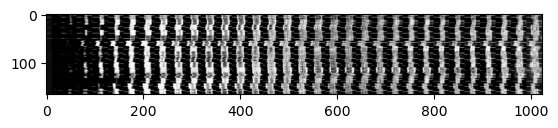

In [14]:
plt.imshow(img,cmap=plt.cm.gray_r)

<AxesSubplot:>

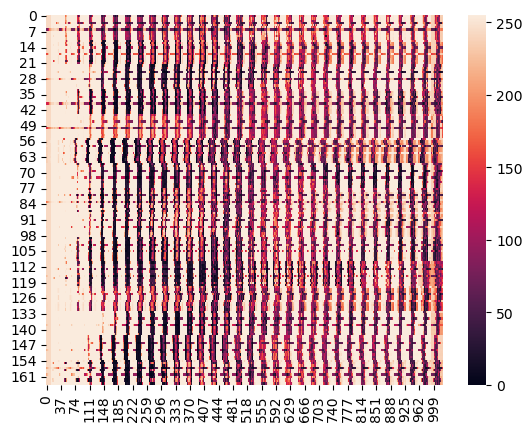

In [15]:
sns.heatmap(img)

x_train shape (55, 1024)
shape of x_train (55, 1024)
shape of y_train (55,)
shape of y_test (110,)
(1024, 55)
(55, 55)
Step 1 Error 0.02122918409107402
Step 2 Error 0.00825839374084659
Step 3 Error 0.0050379710029685235
Step 4 Error 0.00317532519705104
Step 5 Error 0.0021935989226391484
Step 6 Error 0.0016519848475676476
Step 7 Error 0.001307949311303491
Step 8 Error 0.0010703371038756797
Error 0.0008999161322397285
-----END-----
Model: LDA
Choice: 1

new img shape (165, 55)


<AxesSubplot:>

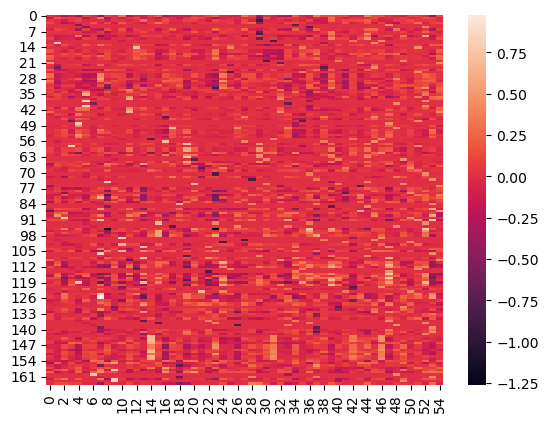

In [16]:
A=preprocessing(img,labels,method='FSSL_LDA',plot=False,choice=None,tsize=5)
new_img=img@A
print('new img shape',new_img.shape)
sns.heatmap(img@A)

In [17]:
# start=time.time()
# fssl_img=preprocessing(img,labels,method='FSSL_LPP')
# end=time.time()
# extra=end-start
create_table(img,labels,baseline,'base',train_sizes,0)

x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (55, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)
x_train shape (66, 1024)


,5,6,7
Accuracy,0.1,0.1,0.1
Time taken,2.77 ms,2.131 ms,1.869 ms


In [18]:
img.shape

(165, 1024)

In [19]:
img

array([[243, 243, 243, ..., 237, 237, 237],
       [243, 243, 243, ..., 234, 236, 236],
       [243, 243, 243, ..., 234, 236, 236],
       ...,
       [243, 243, 243, ..., 222, 222, 225],
       [243, 243, 243, ..., 217, 217, 216],
       [243, 243, 243, ..., 224, 225, 230]], dtype=uint8)

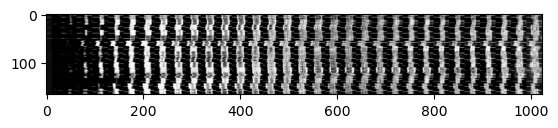

In [20]:
plt.imshow(img,cmap=plt.cm.gray_r)

## Trials
As we can see the above algorithm is not performing well. This is probably due to the small size of dataset and large number of labels. Now we attempt the same algorithm on the digits dataset

In [21]:

print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [22]:
mnist.data

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
mnist.target.shape

(70000,)

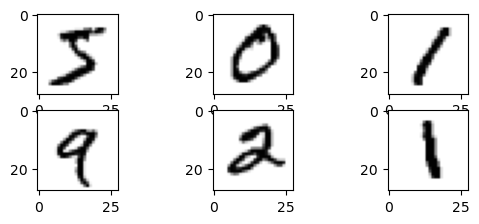

In [24]:
image= mnist.data.to_numpy()
plt.subplot(431)
plt.imshow(image[0].reshape(28,28), cmap=plt.cm.gray_r)
plt.subplot(432)
plt.imshow(image[1].reshape(28,28), cmap=plt.cm.gray_r)
plt.subplot(433)
plt.imshow(image[3].reshape(28,28), cmap=plt.cm.gray_r)
plt.subplot(434)
plt.imshow(image[4].reshape(28,28), cmap=plt.cm.gray_r)
plt.subplot(435)
plt.imshow(image[5].reshape(28,28), cmap=plt.cm.gray_r)
plt.subplot(436)
plt.imshow(image[6].reshape(28,28), cmap=plt.cm.gray_r)

In [25]:
x=mnist.data
y=mnist.target

In [26]:
y

0        5
1        0
2        4
3        1
4        9
        ..
69995    2
69996    3
69997    4
69998    5
69999    6
Name: class, Length: 70000, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

In [27]:
y=np.array(y)
x=np.array(x)
data_filter=np.where((y=='1')|(y=='9')|(y=='6'))

In [28]:
x=x[data_filter]
y=y[data_filter]

In [29]:
x.shape

(21711, 784)

In [30]:
y.shape

(21711,)

In [31]:
# x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.1)

In [32]:
train_sizes=[5,6,7]
create_table(x,y,baseline,'base',train_sizes)

x_train shape (15, 784)
x_train shape (15, 784)
x_train shape (15, 784)
x_train shape (15, 784)
x_train shape (15, 784)
x_train shape (15, 784)
x_train shape (15, 784)
x_train shape (15, 784)
x_train shape (15, 784)
x_train shape (15, 784)
x_train shape (15, 784)
x_train shape (15, 784)
x_train shape (15, 784)
x_train shape (15, 784)
x_train shape (15, 784)
x_train shape (15, 784)
x_train shape (15, 784)
x_train shape (15, 784)
x_train shape (15, 784)
x_train shape (15, 784)
x_train shape (18, 784)
x_train shape (18, 784)
x_train shape (18, 784)
x_train shape (18, 784)
x_train shape (18, 784)
x_train shape (18, 784)
x_train shape (18, 784)
x_train shape (18, 784)
x_train shape (18, 784)
x_train shape (18, 784)
x_train shape (18, 784)
x_train shape (18, 784)
x_train shape (18, 784)
x_train shape (18, 784)
x_train shape (18, 784)
x_train shape (18, 784)
x_train shape (18, 784)
x_train shape (18, 784)
x_train shape (18, 784)
x_train shape (18, 784)
x_train shape (21, 784)
x_train shape (2

,5,6,7
Accuracy,1.0,1.0,1.0
Time taken,120.381 ms,121.87 ms,118.265 ms


In [33]:
# create_table(x,y,LDA,'base')

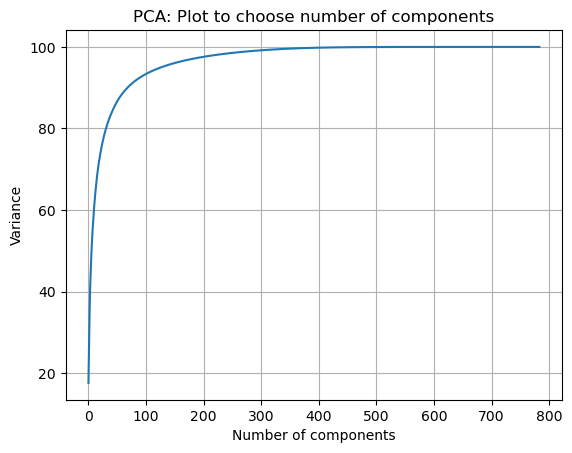

x_train shape (15, 285)
x_train shape (15, 285)
x_train shape (15, 285)
x_train shape (15, 285)
x_train shape (15, 285)
x_train shape (15, 285)
x_train shape (15, 285)
x_train shape (15, 285)
x_train shape (15, 285)
x_train shape (15, 285)
x_train shape (15, 285)
x_train shape (15, 285)
x_train shape (15, 285)
x_train shape (15, 285)
x_train shape (15, 285)
x_train shape (15, 285)
x_train shape (15, 285)
x_train shape (15, 285)
x_train shape (15, 285)
x_train shape (15, 285)
x_train shape (18, 285)
x_train shape (18, 285)
x_train shape (18, 285)
x_train shape (18, 285)
x_train shape (18, 285)
x_train shape (18, 285)
x_train shape (18, 285)
x_train shape (18, 285)
x_train shape (18, 285)
x_train shape (18, 285)
x_train shape (18, 285)
x_train shape (18, 285)
x_train shape (18, 285)
x_train shape (18, 285)
x_train shape (18, 285)
x_train shape (18, 285)
x_train shape (18, 285)
x_train shape (18, 285)
x_train shape (18, 285)
x_train shape (18, 285)
x_train shape (21, 285)
x_train shape (2

,5,6,7
Accuracy,1.0,1.0,1.0
Time taken,58.606 ms,60.471 ms,59.541 ms


In [34]:
create_table(preprocessing(x,y),y,baseline,'base',train_sizes)

In [35]:
# start=time.time()
# fssl_img=preprocessing(x,y,method='FSSL_LDA')
# end=time.time()
# extra=end-start
create_table(x,y,baseline,'FSSL_LDA',train_sizes)

x_train shape (15, 784)
x_train shape (15, 784)
shape of x_train (15, 784)
shape of y_train (15,)
shape of y_test (21696,)
(784, 15)
(15, 15)
Step 1 Error 0.004236371773596191
Step 2 Error 0.0021206047003990637
Step 3 Error 0.0012142758809035442
Error 0.0007316740160963831
-----END-----
Model: LDA
Choice: 1

New data shape (21711, 784)
A shape (784, 15)
new_data shape now (21711, 15)
x_train shape (15, 784)
x_train shape (15, 784)
shape of x_train (15, 784)
shape of y_train (15,)
shape of y_test (21696,)
(784, 15)
(15, 15)
Step 1 Error 0.003577472720940636
Step 2 Error 0.0010943972318802693
Error 0.0007220832689368306
-----END-----
Model: LDA
Choice: 1

New data shape (21711, 784)
A shape (784, 15)
new_data shape now (21711, 15)
x_train shape (15, 784)
x_train shape (15, 784)
shape of x_train (15, 784)
shape of y_train (15,)
shape of y_test (21696,)
(784, 15)
(15, 15)
Step 1 Error 0.0031977089019423585
Error 0.0008981261999113256
-----END-----
Model: LDA
Choice: 1

New data shape (2171

Step 1 Error 0.004093779592747974
Step 2 Error 0.001377240248181436
Error 0.0008303122403391946
-----END-----
Model: LDA
Choice: 1

New data shape (21711, 784)
A shape (784, 18)
new_data shape now (21711, 18)
x_train shape (18, 784)
x_train shape (18, 784)
shape of x_train (18, 784)
shape of y_train (18,)
shape of y_test (21693,)
(784, 18)
(18, 18)
Step 1 Error 0.0038990744716345402
Step 2 Error 0.0012369783319298938
Error 0.000810444996797161
-----END-----
Model: LDA
Choice: 1

New data shape (21711, 784)
A shape (784, 18)
new_data shape now (21711, 18)
x_train shape (18, 784)
x_train shape (18, 784)
shape of x_train (18, 784)
shape of y_train (18,)
shape of y_test (21693,)
(784, 18)
(18, 18)
Step 1 Error 0.004459396075442187
Step 2 Error 0.0012380226844443281
Error 0.0008589846787028807
-----END-----
Model: LDA
Choice: 1

New data shape (21711, 784)
A shape (784, 18)
new_data shape now (21711, 18)
x_train shape (18, 784)
x_train shape (18, 784)
shape of x_train (18, 784)
shape of y_t

x_train shape (21, 784)
x_train shape (21, 784)
shape of x_train (21, 784)
shape of y_train (21,)
shape of y_test (21690,)
(784, 21)
(21, 21)
Step 1 Error 0.005043679801515459
Step 2 Error 0.001701959519861451
Error 0.0009721704549291712
-----END-----
Model: LDA
Choice: 1

New data shape (21711, 784)
A shape (784, 21)
new_data shape now (21711, 21)
x_train shape (21, 784)
x_train shape (21, 784)
shape of x_train (21, 784)
shape of y_train (21,)
shape of y_test (21690,)
(784, 21)
(21, 21)
Step 1 Error 0.004332265457534639
Step 2 Error 0.0012092087021505435
Error 0.0008323342932907851
-----END-----
Model: LDA
Choice: 1

New data shape (21711, 784)
A shape (784, 21)
new_data shape now (21711, 21)
x_train shape (21, 784)
x_train shape (21, 784)
shape of x_train (21, 784)
shape of y_train (21,)
shape of y_test (21690,)
(784, 21)
(21, 21)
Step 1 Error 0.005820854019779742
Step 2 Error 0.0023870647630363454
Step 3 Error 0.0011785844034689814
Error 0.0007219677357504208
-----END-----
Model: LD

,5,6,7
Accuracy,0.92073,0.932066,0.917483
Time taken,517.846 ms,530.396 ms,523.812 ms


In [36]:
x

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

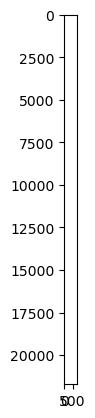

In [37]:
plt.imshow(x,cmap=plt.cm.gray_r)

In [38]:
# start=time.time()
# fssl_img=preprocessing(x,y,method='FSSL_LPP')
# end=time.time()
# extra=end-start
# create_table(fssl_img,y,baseline,'base',train_sizes,extra)

In [39]:
# def transform_to_img(x):
#     start=np.max(x)
#     end=np.min(x)
#     for i in range(x.shape[0]):
#         for j in range(x.shape[1]):
#             x[i,j]=255*(x[i,j]-end)/(start-end)
#             x[i,j]=int(x[i,j])
#     return x
# xx=transform_to_img(fssl_img)
# sns.heatmap(fssl_img)

x_train shape (60, 784)
shape of x_train (60, 784)
shape of y_train (60,)
shape of y_test (21651,)
(784, 60)
(60, 60)
Step 1 Error 0.01109647914285059
Step 2 Error 0.0031039105406234922
Step 3 Error 0.001599115442053463
Error 0.0009718702617027887
-----END-----
Model: LDA
Choice: 1

new img shape (21711, 60)


<AxesSubplot:>

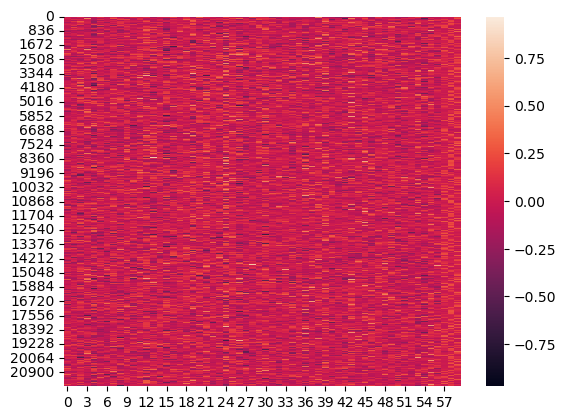

In [40]:
A=preprocessing(x,y,method='FSSL_LDA',plot=False,choice=None,tsize=20)
new_x=x@A
print('new img shape',new_x.shape)
sns.heatmap(x@A)

<AxesSubplot:>

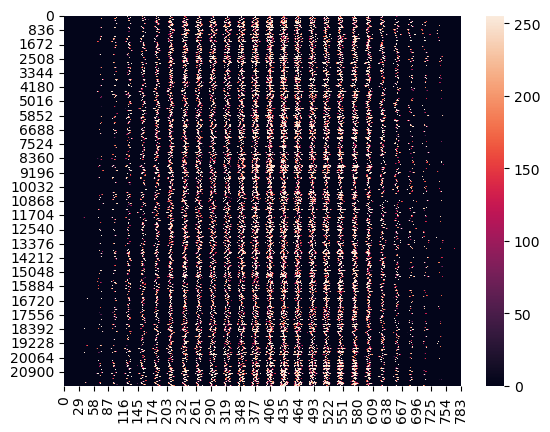

In [41]:
sns.heatmap(x)